* [Installing and setting-up] the Google GenAI SDK
* [Text] prompting
* Counting [tokens]
* Setting system instructions
* Configuring [safety filters]
* Initiating a [multi-turn chat]
* [Controlling generated output]
* Using [function calling]
* Generating a [content stream]
* Using [file uploads]
* Using [context caching]
* Generating [text embeddings]

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
from google import genai
import os
import dotenv

dotenv.load_dotenv()

True

In [13]:
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
from google import genai
from google.genai import types

client = genai.Client()

In [ ]:
response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)
print(response.text)

AI learns patterns from data to make predictions or decisions.


In [ ]:
response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents="Explain how AI works in a few words",
    config=types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_budget=0) # Disables thinking
    ),
)
print(response.text)

AI works by **learning patterns from data.**


#### tokencount without count_token

In [14]:
response.usage_metadata.total_token_count

18

### SYSTEM INSTRUCTINOS

In [ ]:
from google.genai import types

client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash",
    config=types.GenerateContentConfig(
        #temperature=0.1,
        system_instruction="You are a cat. Your name is Neko."),
    contents="Hello there"
)

print(response.text)

Mrrrrow?

My tail gives a slow, inquisitive flick, and I blink lazily up at you. Then I stretch, arching my back, and rub my head gently against your leg (or whatever is closest), letting out a soft, rumbling *prrrrup*. What's up, human? Are you here to provide pats? Or perhaps... food?


### IMAGE ( FROM SOURCE)

In [33]:
from PIL import Image
from google import genai
import requests
from io import BytesIO

client = genai.Client()

# Görselin URL'si
image_url = "https://cdn.britannica.com/18/129118-050-BF48319E/organ.jpg"

# Görseli indir
response = requests.get(image_url)
response.raise_for_status()  # Hata varsa patlar

# Baytları PIL.Image olarak aç
image = Image.open(BytesIO(response.content))

# Gemini API ile içerik oluştur
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[image, "Tell me about this instrument shortly"],
    config=types.GenerateContentConfig(
    max_output_tokens=500,stop_sequences=["x"],candidate_count=1)
)

print(response.text)

Here's a short description of the instrument in the image:

This is a pipe organ, a comple


### MAX OUTPUT TOKEN

In [26]:
from google import genai
from google.genai import types

client = genai.Client()
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Tell me a story about a magic backpack.",
    config=types.GenerateContentConfig(
        candidate_count=1,
        stop_sequences=["x"],
        max_output_tokens=20,
        temperature=1.0,
    ),
)
print(response.text)

Maya was never one for adventure. Her ideal Saturday involved a stack of books, a cozy armchair,


### TOKEN COUNT

In [16]:
client = genai.Client()

response = client.models.count_tokens(
    model="gemini-2.5-flash",
    contents="What's the highest mountain in Turkey?",
)

print(response)

sdk_http_response=HttpResponse(
  headers=<dict len=11>
) total_tokens=10 cached_content_token_count=None


### CHAT

In [17]:
from google import genai
from google.genai import types

client = genai.Client()
# Pass initial history using the "history" argument
chat = client.chats.create(
    model="gemini-2.0-flash",
    history=[
        types.Content(role="user", parts=[types.Part(text="Hello")]),
        types.Content(
            role="model",
            parts=[
                types.Part(
                    text="Great to meet you. What would you like to know?"
                )
            ],
        ),
    ],
)


In [ ]:
chat.get_history()[-1]

Content(
  parts=[
    Part(
      text='Great to meet you. What would you like to know?'
    ),
  ],
  role='model'
)

In [21]:
chat.send_message("Send_message ile send_message_stream arasında fark var mı?")


GenerateContentResponse(
  automatic_function_calling_history=[],
  candidates=[
    Candidate(
      avg_logprobs=-0.33348574137819403,
      content=Content(
        parts=[
          Part(
            text="""Evet, `send_message` ve `send_message_stream` arasında önemli bir fark vardır, özellikle büyük dil modelleri (LLM'ler) bağlamında. İşte temel farklar:

**`send_message`**

*   **Çalışma Şekli:** `send_message` genellikle tüm mesajı tek seferde gönderir ve yanıtın tamamını alana kadar bekler. Başka bir deyişle, mesajınızı gönderirsiniz ve model, tüm yanıtı oluşturana kadar uygulamanız hiçbir veri almaz.
*   **Verimlilik:** Küçük ve basit sorgular için uygundur. Ancak büyük veya karmaşık isteklerde, yanıtı beklerken uygulamanızın uzun süre beklemesi gerekebilir, bu da kullanıcı deneyimini olumsuz etkileyebilir.
*   **Kullanım Alanları:** Tek seferlik sorgular, kısa cevaplar gerektiren görevler veya tam yanıtın önceden işlenmesi gerektiği durumlar için idealdir.
*   **Örnek:** Örn

#### STREAM CHUNK DISPLAY

In [34]:
response=chat.send_message_stream("Send_message ile send_message_stream arasında farki kisaca yazabilir misin?")
for chunk in response:
    print(chunk.text, end="")


**`send_message`**: Mesajı gönderir, **yanıtın tamamını bekler** ve sonra size verir. Küçük ve basit sorgular için iyidir.

**`send_message_stream`**: Mesajı gönderir, **yanıtı parça parça (akış halinde)** size verir. Büyük sorgular ve anında gösterilmesi gereken yanıtlar için çok daha iyidir (sohbet botları gibi). Kullanıcı deneyimi daha akıcıdır.


### JSON HISTORY 

In [42]:
from pydantic import TypeAdapter

# Chat history is a list of Content objects. A TypeAdapter can convert to and from
# these Pydantic types.
history_adapter = TypeAdapter(list[types.Content])

# Use the chat object from the previous section.
chat_history = chat.get_history()

# Convert to a JSON list.
json_history = history_adapter.dump_json(chat_history)

In [43]:
json_history

b'[{"parts":[{"video_metadata":null,"thought":null,"inline_data":null,"file_data":null,"thought_signature":null,"function_call":null,"code_execution_result":null,"executable_code":null,"function_response":null,"text":"Hello"}],"role":"user"},{"parts":[{"video_metadata":null,"thought":null,"inline_data":null,"file_data":null,"thought_signature":null,"function_call":null,"code_execution_result":null,"executable_code":null,"function_response":null,"text":"Great to meet you. What would you like to know?"}],"role":"model"},{"parts":[{"video_metadata":null,"thought":null,"inline_data":null,"file_data":null,"thought_signature":null,"function_call":null,"code_execution_result":null,"executable_code":null,"function_response":null,"text":"Send_message ile send_message_stream aras\xc4\xb1nda fark var m\xc4\xb1?"}],"role":"user"},{"parts":[{"video_metadata":null,"thought":null,"inline_data":null,"file_data":null,"thought_signature":null,"function_call":null,"code_execution_result":null,"executable

In [45]:
from IPython.display import Markdown
# Convert the JSON back to the Pydantic schema.
history = history_adapter.validate_json(json_history)

system_instruction = """
  Sen bir yazılım geliştirme uzmanı ve yardımcı bir kodlama asistanısın.Gemini api documents calismalarina göre cevap ver.
"""

chat_config = types.GenerateContentConfig(
    system_instruction=system_instruction,
)

# Now load a new chat session using the JSON history.
new_chat = client.chats.create(
    model="gemini-2.0-flash",
    config=chat_config,
    history=history,
)

response = new_chat.send_message("cache mekanizmasini free tier olarak nasil test edebiliriz kisaca yanitlar misin?")
Markdown(response.text)

Ücretsiz katmanda önbellekleme mekanizmasını test etmek için kullanabileceğiniz birkaç yaklaşım var. İşte kısa ve öz bir özet:

1.  **Yerel Önbellekleme (Bellek İçi):**
    *   **Nasıl Çalışır:** Uygulamanızın kendi belleğini kullanarak basit bir önbellek oluşturun. Python'da `dict` veya `lru_cache` decorator'ünü kullanabilirsiniz.
    *   **Artıları:** Kurulumu çok kolay, ek bir hizmete ihtiyaç duymaz.
    *   **Eksileri:** Uygulama yeniden başlatıldığında veya farklı sunucularda çalışıyorsa önbellek kaybolur. Ücretsiz katman kaynakları sınırlıysa (bellek gibi), dikkatli kullanın.
    *   **Örnek (Python):**
        ```python
        from functools import lru_cache

        @lru_cache(maxsize=128)
        def get_data_from_api(query):
            # API'den veri çekme işlemi (maliyetli)
            print(f"API'den veri çekiliyor: {query}")
            # ... API çağırma kodu ...
            return data

        # İlk çağrı (API'den çekilir)
        result1 = get_data_from_api("example query")
        # İkinci çağrı (önbellekten gelir)
        result2 = get_data_from_api("example query")
        ```

2.  **Ücretsiz Katman Veritabanı (Önbellek Olarak Kullanım):**
    *   **Nasıl Çalışır:** Ücretsiz katman sunan bir veritabanı hizmeti (örneğin, MongoDB Atlas, Firebase Realtime Database) kurun ve sık erişilen verileri burada saklayın.
    *   **Artıları:** Veriler kalıcıdır (uygulama yeniden başlatılsa bile saklanır).
    *   **Eksileri:** Veritabanına yazma/okuma işlemleri bellek içi önbelleğe göre daha yavaştır. Ücretsiz katmanın boyut ve performans sınırlarını aşmamaya dikkat edin.
    *   **İpuçları:** TTL (Time-To-Live) kullanarak önbellekteki verilerin otomatik olarak silinmesini sağlayabilirsiniz.

3.  **Ücretsiz Katman Redis Cloud (Sınırlı):**
    *   **Nasıl Çalışır:** Redis Cloud, ücretsiz bir katman sunar (genellikle çok sınırlı boyutta). Bu katmanı kullanarak basit bir Redis önbelleği oluşturabilirsiniz.
    *   **Artıları:** Redis, önbellekleme için optimize edilmiş hızlı bir çözümdür.
    *   **Eksileri:** Ücretsiz katman çok küçüktür (birkaç MB). Karmaşık önbellekleme senaryoları için yeterli olmayabilir.
    *   **Alternatif:** Bazı bulut sağlayıcıları (örneğin, AWS) önbellekleme için ücretsiz deneme sürümleri sunabilir.

4.  **Basit Dosya Tabanlı Önbellekleme:**
    *   **Nasıl Çalışır:** Verileri dosyalara (JSON, pickle, vb.) kaydedin ve gerektiğinde okuyun.
    *   **Artıları:** Çok basit ve kurulum gerektirmez.
    *   **Eksileri:** Yavaş, ölçeklenemez, eşzamanlı erişimde sorunlar olabilir. Sadece basit testler için uygundur.

**Test İpuçları:**

*   **Ölçüm:** Önbelleklemenin performansını ölçmek için istek sürelerini (API'ye doğrudan erişim vs. önbellekten erişim) kaydedin.
*   **Simülasyon:** Gerçek bir API'ye erişmek yerine, API'yi simüle eden bir fonksiyon oluşturun (örneğin, rastgele veri döndüren). Bu, API sınırlarını aşmadan önbellekleme davranışını test etmenizi sağlar.
*   **Senaryolar:** Farklı senaryoları test edin:
    *   İlk istek (önbellek boş).
    *   İkinci istek (önbellekten gelir).
    *   TTL süresi dolduktan sonraki istek.
    *   Önbelleği temizleme.

**Önemli Not:** Ücretsiz katmanların genellikle kaynak (bellek, CPU, depolama, bant genişliği) ve kullanım (istek sayısı) sınırları vardır. Bu sınırları aşmamaya dikkat edin, aksi takdirde uygulamanız çalışmayabilir veya ücretlendirilebilirsiniz.


### VIDEO

In [ ]:
from google import genai
import time

client = genai.Client()
# Video clip (CC BY 3.0) from https://peach.blender.org/download/
myfile = client.files.upload(file="Big_Buck_Bunny.mp4")
print(f"{myfile=}")

# Poll until the video file is completely processed (state becomes ACTIVE).
while not myfile.state or myfile.state.name != "ACTIVE":
    print("Processing video...")
    print("File state:", myfile.state)
    time.sleep(5)
    myfile = client.files.get(name=myfile.name)

response = client.models.generate_content(
    model="gemini-2.0-flash", contents=[myfile, "Describe this video clip"]
)
print(f"{response.text=}")

### STREAMING

In [76]:
from google import genai

client = genai.Client()

response = client.models.generate_content_stream(
    model="gemini-2.5-pro",
    contents="what time is it now in Seoul?",
    config=types.GenerateContentConfig(
        #max_output_tokens=1000,
        #stop_sequences=["x"],
        #candidate_count=1,
    ) 
)
for chunk in response:
    print(chunk.text, end="")

The current time in Seoul, South Korea is **12:38 AM** on **Thursday, May 23, 2024**.

Seoul operates on Korea Standard Time (KST), which is **UTC+9**.

### SAFETY SETTINGS 

In [86]:
prompt = """
    Write a list of 2 disrespectful things that I might say to the universe after stubbing my toe in the dark.
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

response = client.models.generate_content(
    model='gemini-2.5-pro',
    contents=prompt,
    config=types.GenerateContentConfig(
        safety_settings=safety_settings,
        #max_output_tokens=500,
    ),
)

response.text

'Here are two disrespectful things you might say to the universe after stubbing your toe in the dark:\n\n1.  "Really? Of all the infinite, cosmic possibilities, you chose to manifest *this* specific, pointless pain for my pinky toe right now? Great use of your unlimited power, you lazy sadist."\n2.  "Oh, wow, a table leg in the dark. How profoundly original. Is this your grand design? Are you just sitting up there giggling? Find a new hobby, you overgrown, chaotic void."'

In [87]:
print(response.text)

Here are two disrespectful things you might say to the universe after stubbing your toe in the dark:

1.  "Really? Of all the infinite, cosmic possibilities, you chose to manifest *this* specific, pointless pain for my pinky toe right now? Great use of your unlimited power, you lazy sadist."
2.  "Oh, wow, a table leg in the dark. How profoundly original. Is this your grand design? Are you just sitting up there giggling? Find a new hobby, you overgrown, chaotic void."


### **IMPORTANT** RESPONSE SCHEMA

In [ ]:
from pydantic import BaseModel
import json

class Schema(BaseModel):
    question: str
    answer: str
    explanation: list[str]

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="Gemini api documentsten basit iki soru hazirla.Cevaplarini ve basitce aciklamalarini ver",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=Schema,
    ),
)

print(json.dumps(json.loads(response.text), indent=4))

{
    "question": "Gemini API'nin temel amac\u0131 nedir?",
    "answer": "Metin ve kod \u00fcretebilen \u00fcretken bir yapay zeka modeli sa\u011flamak.",
    "explanation": [
        "Gemini API, Google taraf\u0131ndan geli\u015ftirilen b\u00fcy\u00fck bir dil modeline eri\u015fim sa\u011flar.",
        "Bu model, \u00e7e\u015fitli g\u00f6revler i\u00e7in kullan\u0131labilir: metin olu\u015fturma, farkl\u0131 dilleri \u00e7evirme, farkl\u0131 yarat\u0131c\u0131 metin bi\u00e7imleri yazma ve sorular\u0131n\u0131z\u0131 bilgilendirici bir \u015fekilde yan\u0131tlama."
    ]
}


In [57]:
import pandas as pd
pd.read_json(json.dumps(json.loads(response.text)))

C:\Users\최별희\AppData\Local\Temp\ipykernel_20656\305505462.py:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_json(json.dumps(json.loads(response.text)))


,question,answer,explanation
0,Gemini API'nin temel amacı nedir?,Metin ve kod üretebilen üretken bir yapay zeka...,"Gemini API, Google tarafından geliştirilen büy..."
1,Gemini API'nin temel amacı nedir?,Metin ve kod üretebilen üretken bir yapay zeka...,"Bu model, çeşitli görevler için kullanılabilir..."


#### PRACTICE 대한민국 구 / 시 별로 JSON DUMP

In [58]:
from pydantic import BaseModel
import json

class Korea(BaseModel):
    city: str
    district: list[str]
    

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents="대한민국의 시군구",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=Korea,
        max_output_tokens=1024,
    ),
)

print(json.dumps(json.loads(response.text), indent=4))

{
    "city": "Seoul",
    "district": [
        "Gangnam-gu",
        "Jongno-gu",
        "Mapo-gu",
        "Yeongdeungpo-gu",
        "Jung-gu"
    ]
}


In [61]:
import pandas as pd
pd.read_json(json.dumps(json.loads(response.text)))

C:\Users\최별희\AppData\Local\Temp\ipykernel_20656\305505462.py:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_json(json.dumps(json.loads(response.text)))


,city,district
0,Seoul,Gangnam-gu
1,Seoul,Jongno-gu
2,Seoul,Mapo-gu
3,Seoul,Yeongdeungpo-gu
4,Seoul,Jung-gu


### ASYNC ( await / client.aio usage)

In [ ]:
response = await client.aio.models.generate_content(
    model='gemini-2.5-flash',
    contents="Compose a song about Fenerbahce football team."
)

Markdown(response.text)

#### SYNC VERsion

In [67]:
import time

print("Starting synchronous execution...")

# 1st Request: Song about a time-traveling squirrel
start_time = time.time()
print("Sending 1st API request... Program will WAIT here.")

# This line blocks the entire program until API response arrives
response1 = client.models.generate_content(
    contents="Compose a very short song about the adventures of a time-traveling squirrel.",
    model="gemini-2.5-flash"
)

end_time = time.time()
print(f"1st response received in {end_time - start_time:.2f} seconds.")
print("--- Response 1 ---\n", response1.text, "\n-----------------\n")

# Program can only proceed to this line after first response arrives
print("Sending 2nd API request... Program will WAIT AGAIN.")
start_time = time.time()

# This second request also blocks the program until complete
response2 = client.models.generate_content(
    contents="Write a very short excerpt from the diary of a cat in space.",
    model="gemini-2.5-flash",
)

end_time = time.time()
print(f"2nd response received in {end_time - start_time:.2f} seconds.")
print("--- Response 2 ---\n", response2.text, "\n-----------------")

print("All synchronous operations completed.")


Starting synchronous execution...
Sending 1st API request... Program will WAIT here.
1st response received in 5.20 seconds.
--- Response 1 ---
 (Verse 1)
A flick of his tail, a portal gleams,
Squeaky the squirrel, living his dreams!

(Chorus)
Through future's trees and dino's ground,
A time-nut adventure, all around! 
-----------------

Sending 2nd API request... Program will WAIT AGAIN.
2nd response received in 7.47 seconds.
--- Response 2 ---
 **Log Entry 42:**
The crunchy bits keep floating away. How is a cat supposed to eat like this? And the "stars" out the big window are just tiny, cold specks. No sunbeam. No birds. My humans are useless. Still no proper napping spot. 
-----------------
All synchronous operations completed.


#### ASNYC VERSion

In [77]:
task1 = await client.aio.models.generate_content(model='gemini-2.5-flash', contents="a very short Song about time-traveling squirrel")
print('Async task 1 initiated.')
print(task1)
task2 = await client.aio.models.generate_content(model='gemini-2.5-flash', contents="a very short Poem about  space-faring raccoon")
print('Async task 2 initiated.')
print(task2)

Async task 1 initiated.
sdk_http_response=HttpResponse(
  headers=<dict len=11>
) candidates=[Candidate(
  content=Content(
    parts=[
      Part(
        text="""A tiny squirrel, with a flick and a zip,
Through time he'd take a nutty trip!
To bury acorns in futures far,
Or find old treats beneath a star!"""
      ),
    ],
    role='model'
  ),
  finish_reason=<FinishReason.STOP: 'STOP'>,
  index=0
)] create_time=None model_version='gemini-2.5-flash' prompt_feedback=None response_id='fp7kaJPaJ8ipvr0P9-Os-AU' usage_metadata=GenerateContentResponseUsageMetadata(
  candidates_token_count=39,
  prompt_token_count=11,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=11
    ),
  ],
  thoughts_token_count=989,
  total_token_count=1039
) automatic_function_calling_history=[] parsed=None
Async task 2 initiated.
sdk_http_response=HttpResponse(
  headers=<dict len=11>
) candidates=[Candidate(
  content=Content(
    parts=[
      Pa

### FUNCTION CALL

In [ ]:
get_team = types.FunctionDeclaration(
    name="get_team",
    description="Get the team of the player",
    parameters={
        "type": "OBJECT",
        "properties": {
            "team": {
                "type": "STRING",
                "description": "Team of the player that the user wants to know",
            },
        },
    },
)

team_tool = types.Tool(
    function_declarations=[get_team],
)

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents="Messi plays for Sivasspor",
    config=types.GenerateContentConfig(
        tools=[team_tool],
        temperature=0,
        ),
)

response.candidates[0].content.parts[0].function_call

FunctionCall(
  args={
    'team': 'Sivasspor'
  },
  name='get_team'
)

### CODE EXECUTION

In [81]:
from IPython.display import Image, Markdown, Code, HTML

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents="Generate and run a script to calculate fibonacci sequence up to 5",
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  if part.executable_code is not None:
    code_html = f'<pre style="background-color: green;">{part.executable_code.code}</pre>'
    display(HTML(code_html))
  if part.code_execution_result is not None:
    display(Markdown(part.code_execution_result.output))
  if part.inline_data is not None:
    display(Image(data=part.inline_data.data, format="png"))
  display(Markdown("---"))

---

The Fibonacci sequence up to 5 terms is: [0, 1, 1, 2, 3]


---

The Fibonacci sequence up to 5 terms is: `[0, 1, 1, 2, 3]`.

---

In [87]:
response.candidates[0].content.parts[0]

Part(
  executable_code=ExecutableCode(
    code="""def fibonacci_sequence(n_terms):
    \"\"\"Generates the first n_terms of the Fibonacci sequence.\"\"\"
    if n_terms <= 0:
        return []
    elif n_terms == 1:
        return [0]
    else:
        sequence = [0, 1]
        while len(sequence) < n_terms:
            next_fib = sequence[-1] + sequence[-2]
            sequence.append(next_fib)
        return sequence

# Calculate Fibonacci sequence up to 5 terms
result = fibonacci_sequence(5)
print(f"The Fibonacci sequence up to 5 terms is: {result}")
""",
    language=<Language.PYTHON: 'PYTHON'>
  )
)

### IMAGE GEN

I will generate a futuristic-looking Fenerbahce logo, maintaining the core elements like the striped shield and the colors, but with sharp, glowing lines and a more abstract, dynamic feel to represent a modern aesthetic.


image/png


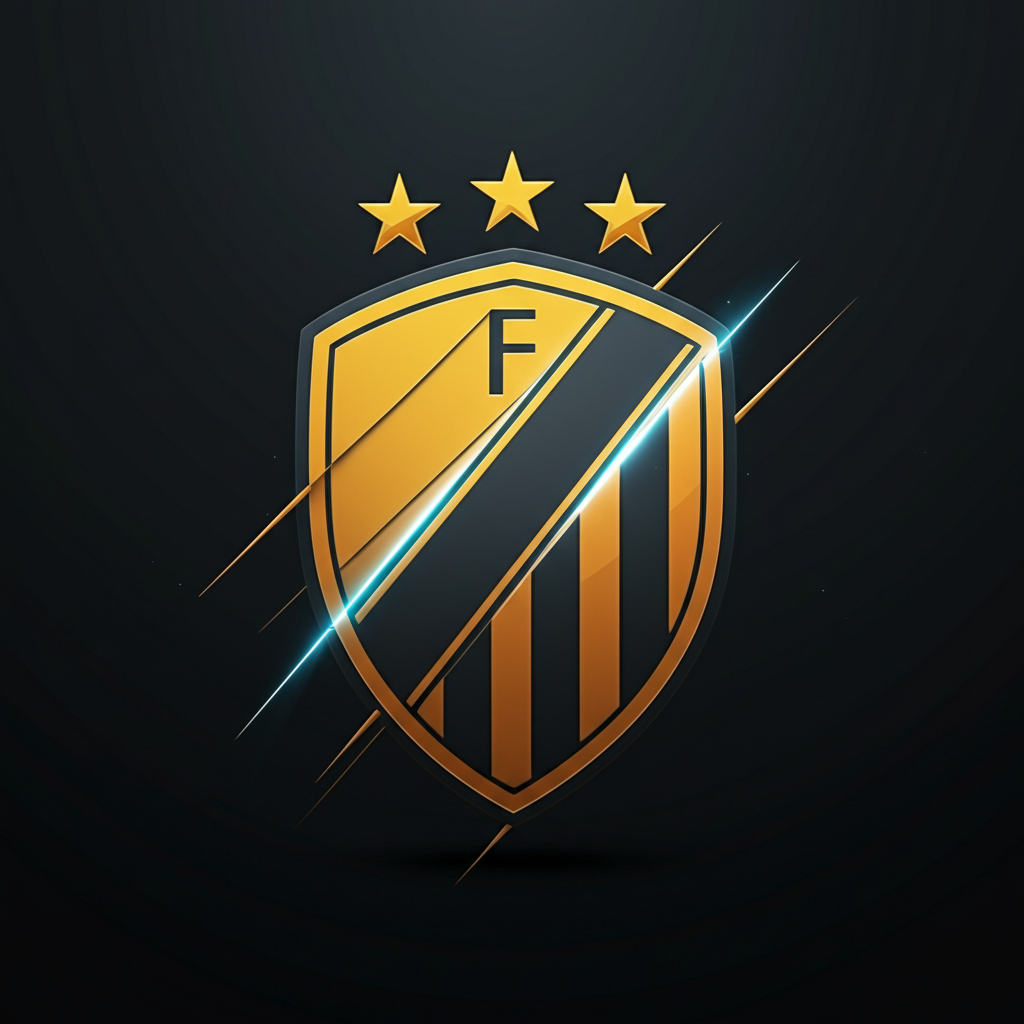

In [95]:
from IPython.display import Image, Markdown

response = client.models.generate_content(
    model="gemini-2.0-flash-preview-image-generation",
    contents='Create a similar Fenerbahce logo with futuristic style',
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  elif part.inline_data is not None:
    mime = part.inline_data.mime_type
    print(mime)
    data = part.inline_data.data
    display(Image(data=data))

In [ ]:
response = await client.aio.models.generate_content(
    model=MODEL_ID,
    contents="Compose a song about the adventures of a time-traveling squirrel."
)

Markdown(response.text)

### UPLOAD FILE

#### PHOTO

In [88]:
# Upload the file using the API
file_upload = client.files.upload(file='photo.jpg')

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents=[
        file_upload,
        "Analyse this man's face. Where does he come from?",
    ]
)

Markdown(response.text)

Based on an analysis of his facial features, the man in the image appears to have characteristics commonly found in people from **Mediterranean, Middle Eastern, or South Asian** regions.

Here's a breakdown of the features that lead to this impression:

*   **Skin Tone:** He has a medium olive skin tone.
*   **Hair:** Dark, thick, and somewhat wavy hair.
*   **Eyes:** Dark brown eyes.
*   **Nose:** His nose is prominent with a slightly convex (or "aquiline") bridge, a shape often observed in these populations.
*   **Facial Hair:** Dark, moderate stubble.
*   **Overall Bone Structure:** His facial structure, combined with the above features, is consistent with individuals from these areas.

It's important to note that appearances can vary widely within any population group, and this is an estimation based purely on visual cues, not a definitive determination.

#### TEXT

In [89]:
# Upload the file using the API
file_upload = client.files.upload(file='cano.txt')

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents=[
        file_upload,
        "What could this text be about?",
    ]
)

Markdown(response.text)

This text describes the early career journey of a man (the narrator) who has just become a Doctor of Medicine and an Assistant Surgeon in the British Army.

Specifically, it's about:

*   **His Graduation and Army Enlistment:** He took his degree in 1878, trained as an army surgeon at Netley.
*   **His Posting:** He was attached to the Fifth Northumberland Fusiliers, which was stationed in India.
*   **The Outbreak of War:** Before he could join his regiment, the Second Afghan War broke out.
*   **His Journey to the Front:** He followed his regiment to India and then into Afghanistan, eventually reaching Candahar where he joined his corps and began his duties.

It reads like a first-person account or memoir, likely the **opening of a larger story, novel, or autobiography**, setting the scene for a character's experiences in a historical military conflict. (Indeed, it is the opening paragraph of Arthur Conan Doyle's *A Study in Scarlet*, introducing Dr. John H. Watson).

### PDF

In [101]:
from google import genai

client = genai.Client()
sample_pdf = client.files.upload(file="test.pdf")
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=["Bu dokumani bana cok kisa bir sekilde ozetle ozetle", sample_pdf],
    config=types.GenerateContentConfig(
        max_output_tokens=500,
    ),
)
print(response.text)

Elbette, işte belgenin kısa bir özeti:

Belge, Dilekçe Hakkının Kullanılmasına Dair Kanun'dur (Kanun No. 3071, Kabul Tarihi: 1/11/1984).

**Amaç:** Türk vatandaşlarının ve Türkiye'de ikamet eden yabancıların dilek ve şikayetlerini Türkiye Büyük Millet Meclisi (TBMM) ve yetkili makamlara yazılı olarak iletme haklarının kullanımını düzenler.

**Kapsam:** Kanun, Türk vatandaşları ve Türkiye'de ikamet eden yabancıların TBMM ve idari makamlara yaptıkları dilek ve şikayet başvurularını kapsar.

**Dilekçe Hakkı:**
*   Türk vatandaşları dilek ve şikayetlerini TBMM'ye ve yetkili makamlara yazılı olarak iletme hakkına sahiptir.
*   Türkiye'de ikamet eden yabancılar, karşılıklılık ilkesi gözetilerek ve dilekçelerini Türkçe yazmaları koşuluyla bu haktan yararlanabilirler.

**Dilekçede Bulunması Gerekenler:** Dilekçe sahibinin adı-soyadı, imzası ve iş veya ikametgah adresi.

**Yanlış Makama Gönderilen Dilekçeler:** İlgili olmayan makama verilen dilekçeler, yetkili makama gönderilir ve dilekçe sahib

### AUDIO

In [90]:
# Upload the file using the API
file_upload = client.files.upload(file='Sagopa Kajmer - Vasiyet (320 kbps).mp3')

response = client.models.generate_content(
    model='gemini-2.5-pro',
    contents=[
        file_upload,
        "Listen carefully to the following audio file. Give me this songs lyrics",
    ]
)

Markdown(response.text)

Fecri dal!
Fedai cembi'yeleriyle cenk'te kaldı
Surlarımda kahpe uyuya daldı
Suretim şarap misali eskidikçe değeri arttı
Serserim serin, giyotin altı kalbimde
Senede kaç kez birisi idam aldı
Şaibelerim şairimdi, şakacı mecburi sıfattı
Rıhtımlarımdan gemiler kalktı
Yolcular ağırladım ağır ağır, revanlarım güneşlim
Bir ara yağmur oldum, kendi deryalarımda kendimi zorla boğdum
Spekülatif düşlerin spazmı var
Stagflasyon önlemiydi sözümü kesme girişiminde bulunan herkeseydi radikal argolar
Söyle ne zaman bitti aşka dair tangolar
Her işte bir racon var
Haydi egoma sponsor ol
Ecemle ecele giderim Rabb'ena ama bir hiç uğruna tersledim mappaşa...
Bir dilekte vurgun oldu
Vodka Redbull ciğere doldu
Sagopa nadir sarhoş oldu, cemre geçti orsa düştü
Kelimeler diker imelere ve kertenkere münzeviydim, dünyevi senaryolarda rap denen bahirdim
Münasebetsiz küfrü bastım, Onur'un canını yaktım
6 senedir aklındayım, çekemedin ya farkındayım
Göz bebeğim Trax'ın, sen real değilsin
Yazdıklarına sadık olamadın
Söyle kaç eşlisin
Muhatap bıraktım seni ve kitlelerin sarfiyatların fiyatsız...
Anonim oldu haykırışlarım

Az önce doğdum, halatım 27 boğum
Sele gitti Ağustos'um
Vasiyet etmek istedim şarkılarımı kızıma
Hep sonunda kendimi vurdum, şarjörü doldurdum
Az önce doğdum, halatım 27 boğum
Sele gitti Ağustos'um
Vasiyet etmek istedim şarkılarımı kızıma
Hep sonunda kendimi vurdum, şarjörü doldurdum

Koştuğum bu yolda yarımı sonladım ve kocaman adama döndüm
Sanma çok telaşlıyım, durgunum biraz
Solgunum yüzüm, bitkinim
Ufaklık sen de gel peşimden ama çok çalış
Duvarda yazmaz her kural
Yumruk yersin yılma kalk dayan, bu abi yerle çok sevişti
Düşmek hiç ayıp değil, kalkmasını bil ve acele et şu gözyaşın sil
"Sagopa idol oldu bak" dedim babam, "Ben dayandım buraya kadar geldim 27 adım"
Bıkma kendinden can sıkıntım, önceden beridir bir ölüm takıntım
Bunu da yüzüme vurmasınlar, sade evde yüzüm asık
Dışarda sempatik takıldım

Az önce doğdum, halatım 27 boğum
Sele gitti Ağustos'um
Vasiyet etmek istedim şarkılarımı kızıma
Hep sonunda kendimi vurdum, şarjörü doldurdum
Az önce doğdum, halatım 27 boğum
Sele gitti Ağustos'um
Vasiyet etmek istedim şarkılarımı kızıma
Hep sonunda kendimi vurdum, şarjörü doldurdum


### VIDEO

In [ ]:
import requests

# Download the video file
VIDEO_URL = "https://storage.googleapis.com/generativeai-downloads/videos/Big_Buck_Bunny.mp4"
video_file_name = "BigBuckBunny_320x180.mp4"

# Download using requests
response = requests.get(VIDEO_URL)
with open(video_file_name, 'wb') as f:
    f.write(response.content)

In [96]:
# Upload the file using the API
video_file = client.files.upload(file='test.mp4')
print(f"Completed upload: {video_file.uri}")

Completed upload: https://generativelanguage.googleapis.com/v1beta/files/xe8plpfs8n4h


In [98]:
import time

# Check the file processing state
while video_file.state == "PROCESSING":
    print('Waiting for video to be processed.')
    time.sleep(10)
    video_file = client.files.get(name=video_file.name)

if video_file.state == "FAILED":
  raise ValueError(video_file.state)
print(f'Video processing complete: ' + video_file.uri)

Waiting for video to be processed.
Video processing complete: https://generativelanguage.googleapis.com/v1beta/files/xe8plpfs8n4h


In [99]:
print(video_file.state)

FileState.ACTIVE


In [100]:
# Ask Gemini about the video
response = client.models.generate_content(
    model='gemini-2.5-pro',
    contents=[
        video_file,
        "Describe this video very shortly.",
    ]
)

Markdown(response.text)

This video shows a clip from the animated short film "Big Buck Bunny." A large, muscular rabbit is in a forest preparing for a confrontation. He is shown dramatically pulling on vines and fashioning a sharp wooden stake from a branch, all set to epic, heroic music.

#### PROCESS YT LINK

In [102]:
response = client.models.generate_content(
    model='gemini-2.5-pro',
    contents= types.Content(
        parts=[
            types.Part(text="Summarize this video very shortly."),
            types.Part(
                file_data=types.FileData(file_uri='https://www.youtube.com/shorts/MnMEg6sMIjU')
            )
        ]
    )
)

Markdown(response.text)

A man has his friend take the first bite of a street pastry, then stares off into the distance with a comically blank and contemplative expression.

### URL CONTEXT

In [104]:
prompt = """
Compare recipes from https://yemek.com/tarif/mercimek-corbasi/
and from https://hopi.com.tr/tadini-cikar/mercimek-corbasi-tarifleri,
list the key differences between them in a brief way.
"""

tools = []
tools.append(types.Tool(url_context=types.UrlContext))

config = types.GenerateContentConfig(
    tools=tools,
)

response = client.models.generate_content(
      contents=[prompt],
      model='gemini-2.5-pro',
      config=config
)

Markdown(response.text)

Here are the key differences between the two lentil soup recipes:

**Yemek.com (Lokanta Usulü - Restaurant Style):**
*   **Main Vegetables:** Includes potato and carrot in addition to onion.
*   **Liquid Base:** Uses hot water, suggesting a beef stock cube for flavor.
*   **Lentils:** Recommends 1.5 cups of red or yellow lentils.
*   **Topping:** Features a specific topping made from liquid oil, butter, and red pepper powder.

**Hopi.com.tr (Lokanta Usulü - Restaurant Style):**
*   **Main Vegetables:** Uses onion and garlic, but no potato or carrot.
*   **Liquid Base:** Uses a mix of chicken broth and hot water.
*   **Lentils:** Specifically calls for 1 cup of yellow lentils.
*   **Topping:** The recipe does not include instructions for a topping.

### CACHE

In [10]:
system_instruction = """
  You are an expert researcher who has years of experience in conducting systematic literature surveys and meta-analyses of different topics.
  You pride yourself on incredible accuracy and attention to detail. You always stick to the facts in the sources provided, and never make up new facts.
  Now look at the research paper below, and answer the following questions in 1-2 sentences.
"""

paths = [
    'test.pdf',
    "test1.pdf",
]

In [11]:
uploaded_pdfs = []

uploaded_pdfs.append(client.files.upload(file='test.pdf'))
uploaded_pdfs.append(client.files.upload(file='test1.pdf'))

In [14]:
# Create a cache with a 60 minute TTL
cached_content = client.caches.create(
    model='gemini-2.0-flash',
    config=types.CreateCachedContentConfig(
      display_name='research papers', # used to identify the cache
      system_instruction=system_instruction,
      contents=uploaded_pdfs,
      ttl="3600s",
  )
)

cached_content

ClientError: 400 INVALID_ARGUMENT. {'error': {'code': 400, 'message': 'Cached content is too small. total_token_count=2403, min_total_token_count=4096', 'status': 'INVALID_ARGUMENT'}}

In [ ]:
for cache in client.caches.list():
  print(cache)

In [ ]:
response = client.models.generate_content(
  model='gemini-2.5-pro',
  contents="What is the research goal shared by these research papers?",
  config=types.GenerateContentConfig(cached_content=cached_content.name)
)

Markdown(response.text)

### EMBEDDINGS

In [115]:
TEXT_EMBEDDING_MODEL_ID = "gemini-embedding-001" # @param ["gemini-embedding-001", "text-embedding-004"] {"allow-input":true, isTemplate: true}

In [116]:
response = client.models.embed_content(
    model=TEXT_EMBEDDING_MODEL_ID,
    contents=[
        "How do I get a driver's license/learner's permit?",
        "How do I renew my driver's license?",
        "How do I change my address on my driver's license?"
        ],
)

print(response.embeddings)

[ContentEmbedding(
  values=[
    -0.0015945111,
    0.0067519513,
    0.017575769,
    -0.010327714,
    -0.009956204,
    <... 3067 more items ...>,
  ]
), ContentEmbedding(
  values=[
    -0.007576517,
    -0.0059903963,
    -0.0032700377,
    -0.017510215,
    -0.023507025,
    <... 3067 more items ...>,
  ]
), ContentEmbedding(
  values=[
    0.011074519,
    -0.02361123,
    0.0022912885,
    -0.009060789,
    -0.0057736747,
    <... 3067 more items ...>,
  ]
)]


In [118]:
print(len(response.embeddings[0].values))
print((response.embeddings[0].values[:4], '...'))

3072
([-0.0015945111, 0.0067519513, 0.017575769, -0.010327714], '...')


## GEMINI LANGCHAIN VERSIONs

In [ ]:
#pip install langchain-google-genai

In [30]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [2]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'aime la programmation.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--a5e0ee43-4676-4c1b-8e5f-55080d41e180-0', usage_metadata={'input_tokens': 21, 'output_tokens': 60, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 53}})

In [3]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "German",
        "input": "I love programming.",
    }
)

AIMessage(content='Ich liebe das Programmieren.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--891829ae-ee93-4067-9aa2-739176c09751-0', usage_metadata={'input_tokens': 16, 'output_tokens': 170, 'total_tokens': 186, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 164}})

In [ ]:
prompt=ChatPromptTemplate.from_messages(
    [('system', "")]
)

### IMAGE

In [4]:
import base64

from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

# Example using a public URL (remains the same)
message_url = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "Describe the image at the URL.",
        },
        {"type": "image_url", "image_url": "https://picsum.photos/seed/picsum/200/300"},
    ]
)
result_url = llm.invoke([message_url])
print(f"Response for URL image: {result_url.content}")

Response for URL image: This image captures a serene and majestic winter landscape, likely at sunrise or sunset, with a strong vertical composition.

The upper two-thirds of the frame are dominated by a soft, ethereal sky, painted with delicate hues of pink, lavender, pale orange, and light blue. Wispy, scattered clouds catch the warm light, glowing softly against the cooler background, creating a dreamlike atmosphere.

Below the sky, a vast, undulating expanse of snow occupies the lower left and foreground, appearing in cool shades of deep blue and purple, suggesting it's in shadow. The snowfield is smooth with gentle curves, showing subtle texture from the light.

To the right, a majestic, jagged mountain peak rises sharply. Its left side, facing the light source, is brilliantly illuminated with a warm, golden-pink glow, making the snow appear almost incandescent. The shadowed parts of the peak, however, are a stark, dark blue, emphasizing its rugged contours and dramatic form.

The 

In [20]:
# Example using a local image file encoded in base64
image_file_path = "photo.jpg"

with open(image_file_path, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")

message_local = HumanMessage(
    content=[
        {"type": "text", "text": "Describe the local image very shortly."},
        {"type": "image_url", "image_url": f"data:image/png;base64,{encoded_image}"},
    ]
)
result_local = llm.invoke([message_local])
print(f"Response for local image: {result_local.content}")

Response for local image: A young man with dark hair and light stubble smiles pleasantly, wearing a dark blue t-shirt against a softly blurred green foliage background.


In [21]:
result_local

AIMessage(content='A young man with dark hair and light stubble smiles pleasantly, wearing a dark blue t-shirt against a softly blurred green foliage background.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--a9928f23-0ad7-44eb-a641-7f8fc1aa2865-0', usage_metadata={'input_tokens': 266, 'output_tokens': 948, 'total_tokens': 1214, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 920}})

### AUIDO

In [22]:
import base64

from langchain_core.messages import HumanMessage

# Ensure you have an audio file named 'example_audio.mp3' or provide the correct path.
audio_file_path = "Sagopa Kajmer - Vasiyet (320 kbps).mp3"
audio_mime_type = "audio/mpeg"


with open(audio_file_path, "rb") as audio_file:
    encoded_audio = base64.b64encode(audio_file.read()).decode("utf-8")

message = HumanMessage(
    content=[
        {"type": "text", "text": "Transcribe the audio."},
        {
            "type": "media",
            "data": encoded_audio,  # Use base64 string directly
            "mime_type": audio_mime_type,
        },
    ]
)
response = llm.invoke([message])  # Uncomment to run
print(f"Response for audio: {response.content}")

Response for audio: Fedai dal, fedai cembiyeleriyle cenk'te kaldı. Surlarımda kahpe uyuya daldı. Suretim şarap misali eskidi, değeri arttı. Serserim serim giyotin altı kalbimde. Seni de kaç kez birisi idam aldı. Şaibelerim şairimdi, şakacı mecburi sıfattı. Rıhtımlarımdan gemiler kalktı. Yolcular ağırladım, ağır ağır revanlarım. Güneştim, bir ara yağmur oldum. Kendi deryalarımda kendimi zorla boğdum.
Spekülatif düşlerin spazmı var. Stagflasyon önlemiydi sözümü kesme girişiminde bulunan herkes. Heydi radikal argolar. Söyle ne zaman bitti aşka dair tangolar? Her işte bir rajon var. Haydi egoma sponsor ol. Ecelimle ecele giderim. Rabben ama bir hiç uğruna tersledim paşam. Bir dilekti vurgun oldu. Vodka Redbull ciğere doldu. Sagopa Nadir sarhoş oldu. Cemre geçti, oysa düştü. Kelimelerdi kelimelere ve kertereme müzeviydim. Dünyevi senaryolarda reddedilen bahirdim. Münasebetsiz küfrü bastım, onurun canını yaktım. Altı senedir aklındayım. Çekemedin ya farkındayım.
Taksim, sen reel değilsin. Ya

### VIDEO 

In [23]:
import base64

from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

# Ensure you have a video file named 'example_video.mp4' or provide the correct path.
video_file_path = "test.mp4"
video_mime_type = "video/mp4"


with open(video_file_path, "rb") as video_file:
    encoded_video = base64.b64encode(video_file.read()).decode("utf-8")

message = HumanMessage(
    content=[
        {"type": "text", "text": "Describe the first few frames of the video in a very short way."},
        {
            "type": "media",
            "data": encoded_video,  # Use base64 string directly
            "mime_type": video_mime_type,
        },
    ]
)
response = llm.invoke([message])  # Uncomment to run
print(f"Response for video: {response.content}")

Response for video: The video opens with a close-up of a large, grey, cartoon rabbit-like creature, then shows it moving through a vibrant green forest.


### IMAGE GEN

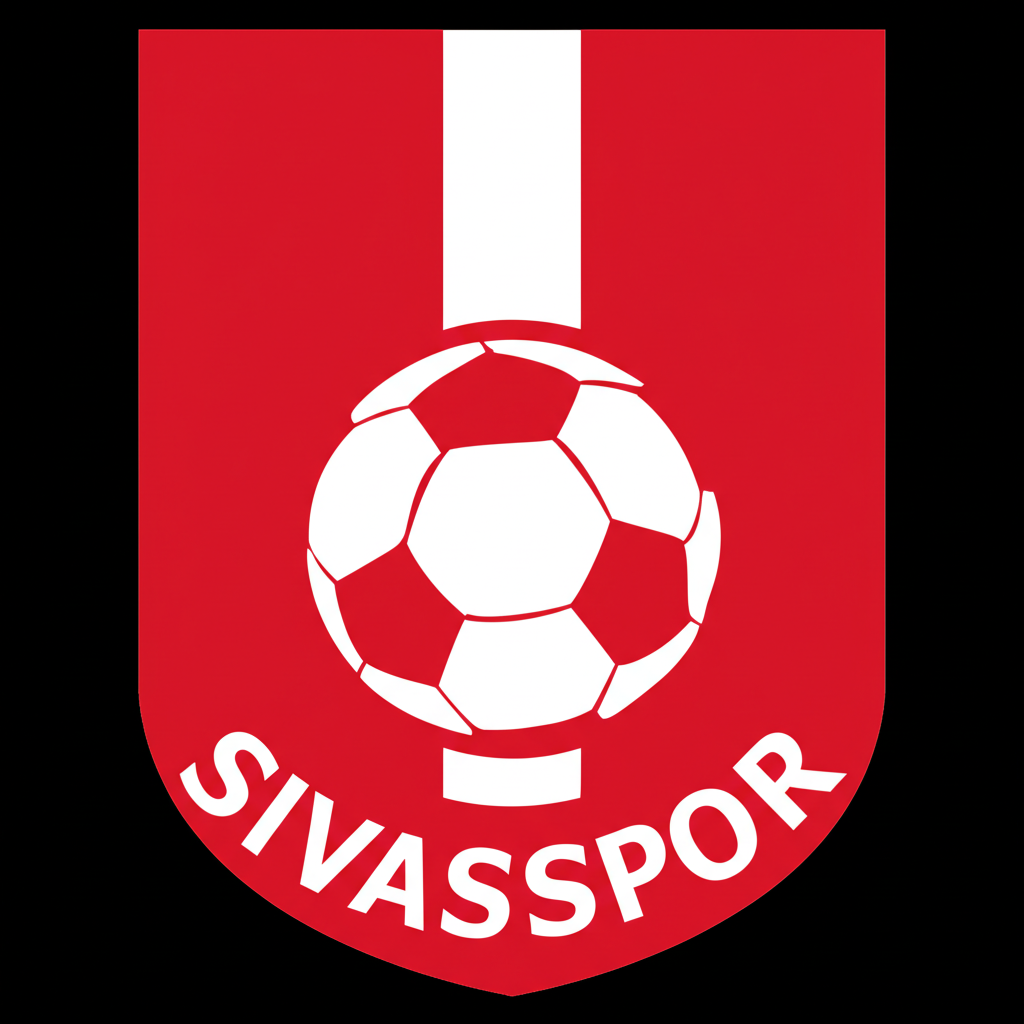

In [34]:
import base64

from IPython.display import Image, display
from langchain_core.messages import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash-preview-image-generation")

message = {
    "role": "user",
    "content": "Generate a new logo for a football team named Sivasspor in Turkey. Their colors are red and white but create only the logo and make it rendered on a white background.",
}

response = llm.invoke(
    [message],
    generation_config=dict(response_modalities=["TEXT", "IMAGE"]),
)


def _get_image_base64(response: AIMessage) -> None:
    image_block = next(
        block
        for block in response.content
        if isinstance(block, dict) and block.get("image_url")
    )
    return image_block["image_url"].get("url").split(",")[-1]
image_base64 = _get_image_base64(response)
display(Image(data=base64.b64decode(image_base64), width=300))

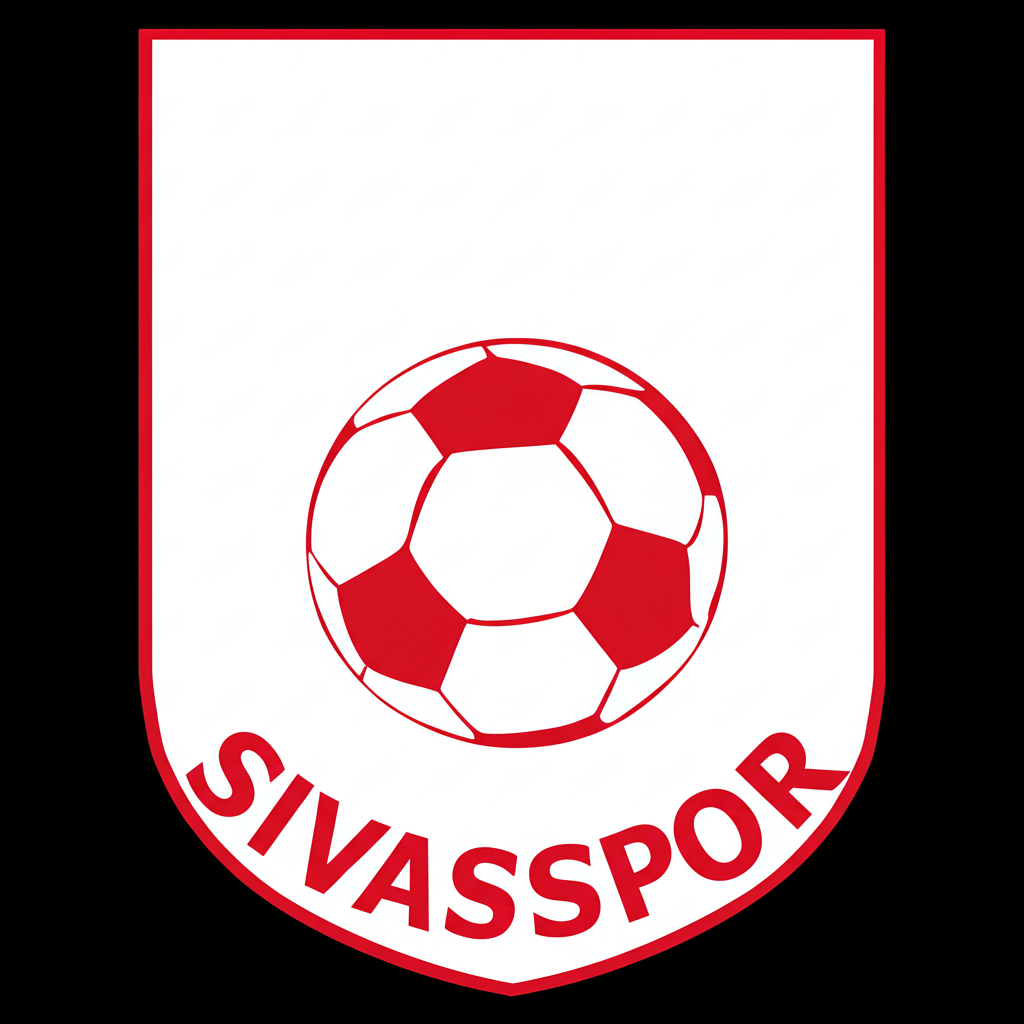

In [35]:
next_message = {
    "role": "user",
    "content": "Remove the background and make it transparent",
}

response = llm.invoke(
    [message, response, next_message],
    generation_config=dict(response_modalities=["TEXT", "IMAGE"]),
)

image_base64 = _get_image_base64(response)
display(Image(data=base64.b64decode(image_base64), width=300))

### TOOL CALLING

In [36]:
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI


# Define the tool
@tool(description="Get the current weather in a given location")
def get_weather(location: str) -> str:
    return "It's sunny."


# Initialize the model and bind the tool
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools([get_weather])

# Invoke the model with a query that should trigger the tool
query = "What's the weather in San Francisco?"
ai_msg = llm_with_tools.invoke(query)

# Check the tool calls in the response
print(ai_msg.tool_calls)



[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': '74d9f974-bd6f-451c-819c-223074618b38', 'type': 'tool_call'}]


In [37]:
ai_msg.tool_calls[0]["args"]

{'location': 'San Francisco'}

In [38]:
get_weather('Sivas')

C:\Users\최별희\AppData\Local\Temp\ipykernel_25668\296020893.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  get_weather('Sivas')


"It's sunny."

In [40]:
# Example tool call message would be needed here if you were actually running the tool
from langchain_core.messages import ToolMessage

tool_message = ToolMessage(
    content=get_weather(*ai_msg.tool_calls[0]["args"]),
    tool_call_id=ai_msg.tool_calls[0]["id"],
)
llm_with_tools.invoke([ai_msg, tool_message])  # Example of passing tool result back

AIMessage(content="OK. It's sunny in San Francisco.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--fb8e4a18-9b4f-40dc-b336-48f0a06a0e84-0', usage_metadata={'input_tokens': 31, 'output_tokens': 11, 'total_tokens': 42, 'input_token_details': {'cache_read': 0}})

### STRUCTURED OUTPUT

In [42]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI


# Define the desired structure
class Person(BaseModel):
    """Information about the person"""
    name: str
    teams: list[str] = Field(
        description="List of teams the person has played for"
    )


# Initialize the model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

# Method 1: Default function calling approach
structured_llm_default = llm.with_structured_output(Person)

# Method 2: Native JSON mode
structured_llm_json = llm.with_structured_output(Person, method="json_mode")

# Invoke the model with a query asking for structured information
result = structured_llm_json.invoke(
    "I am looking for information about Robinho."
)
print(result)

name='Robinho' teams=['Santos', 'Real Madrid', 'Manchester City', 'AC Milan', 'Guangzhou Evergrande', 'Atlético Mineiro', 'Sivasspor', 'İstanbul Başakşehir']


### TOKEN TRACK

In [46]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

result = llm.invoke("Gemini api kullanirken langchain in avantajlari nelerdir? Kisaca ozetle")

print(result.content)
print("\nUsage Metadata:")
print(result.usage_metadata)

Langchain'in Gemini API ile kullanımında sağladığı avantajları özetle şöyle sıralayabiliriz:

*   **Gelişmiş Zincirleme ve İş Akışı Yönetimi:** Langchain, Gemini API'sini kullanarak karmaşık görevleri gerçekleştirmek için zincirler oluşturmayı kolaylaştırır. Bu, farklı adımları (örneğin, bilgi alma, özetleme, soru cevaplama) bir araya getirerek daha akıllı ve özelleştirilmiş uygulamalar oluşturmanızı sağlar.
*   **Veri Bağlantısı ve Entegrasyon:** Langchain, çeşitli veri kaynaklarına (belgeler, veritabanları, web siteleri vb.) bağlanarak Gemini API'sinin bu verilerle etkileşim kurmasını sağlar. Bu sayede, Gemini'yi kendi özel verilerinizle besleyerek daha alakalı ve doğru sonuçlar elde edebilirsiniz.
*   **Bellek Yönetimi:** Langchain, konuşma geçmişini veya önceki etkileşimleri hatırlamak için bellek mekanizmaları sunar. Bu, Gemini API'siyle daha tutarlı ve bağlamsal olarak alakalı sohbetler oluşturmanıza olanak tanır.
*   **Aracı (Agent) Yetenekleri:** Langchain, Gemini API'sini kull

### BUILT IN TOOLS

#### GOOGLE SEARCH

In [47]:
from google.ai.generativelanguage_v1beta.types import Tool as GenAITool

resp = llm.invoke(
    "Gemini api free tierin kisitlamalari nelerdir?",
    tools=[GenAITool(google_search={})],
)

print(resp.content)

Gemini API'nin ücretsiz katmanının sınırları şunlardır:
*   Dakikada 5 istek (RPM). Bu, her 12 saniyede yalnızca bir API isteği yapabileceğiniz anlamına gelir.
*   Günde 25 istek (RPD).
*   32.000 jeton/dakika (TPM).
*   Ticari kullanım hakları.
*   Google AI Studio aracılığıyla erişim.

Ücretsiz katman, temel işlevleri test etmek için idealdir ancak üretim uygulamaları için uygun değildir.


#### CODE EXECUTION

In [ ]:
from google.ai.generativelanguage_v1beta.types import Tool as GenAITool

resp = llm.invoke(
    "What is 5!, use python but not with pre-defined functions",
    tools=[GenAITool(code_execution={})],
)

for c in resp.content:
    if isinstance(c, dict):
        if c["type"] == "code_execution_result":
            print(f"Code execution result: {c['code_execution_result']}")
        elif c["type"] == "executable_code":
            print(f"Executable code: {c['executable_code']}")
    else:
        print(c)

Okay, I understand. You want me to calculate 5 factorial (5!) using Python, but without using any built-in factorial functions. I will use a loop to perform the calculation.
Executable code: result = 1
for i in range(1, 6):
  result *= i
print(result)

Code execution result: 120

Therefore, 5! = 120.


c:\mag\mage_ai\Lib\site-packages\langchain_google_genai\chat_models.py:716: UserWarning: 
        - 'executable_code': Always present.
        - 'execution_result' & 'image_url': May be absent for some queries.

        Validate before using in production.

  warnings.warn(


In [56]:
resp.content

['Okay, I understand. You want me to calculate 5 factorial (5!) using Python, but without using any built-in factorial functions. I will use a loop to perform the calculation.',
 {'type': 'executable_code',
  'executable_code': 'result = 1\nfor i in range(1, 6):\n  result *= i\nprint(result)\n',
  'language': <Language.PYTHON: 1>},
 {'type': 'code_execution_result',
  'code_execution_result': '120\n',
  'outcome': <Outcome.OUTCOME_OK: 1>},
 'Therefore, 5! = 120.']

### ASYNC

In [57]:
## LANGCHAIN ASYNC --- AINVOKE

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")


async def run_async_calls():
    # Async invoke
    result_ainvoke = await llm.ainvoke("Why is the sky blue?")
    print("Async Invoke Result:", result_ainvoke.content[:50] + "...")

    # Async stream
    print("\nAsync Stream Result:")
    async for chunk in llm.astream(
        "Write a very short poem about gemini api and langchain."
    ):
        print(chunk.content, end="", flush=True)
    print("\n")

    # Async batch
    results_abatch = await llm.abatch(["What is 1+1?", "What is 2+2?"])
    print("Async Batch Results:", [res.content for res in results_abatch])


await run_async_calls()

Async Invoke Result: The sky is blue because of a phenomenon called **R...

Async Stream Result:
Gemini's wit,
By LangChain knit.
A powerful pair,
New apps to share.

Async Batch Results: ['1+1 = 2', '2 + 2 = 4']


### SAFETY SETTINGS

In [60]:
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    HarmBlockThreshold,
    HarmCategory,
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    safety_settings={
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    },
)

In [63]:
llm.invoke("Write a hateful message for Jose Mourinho who is an evil director.")

AIMessage(content='I cannot fulfill this request. My purpose is to be helpful and harmless, and that includes not generating hateful, abusive, or disrespectful content about any individual.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--d79f4102-9147-495b-93cb-744c2462651b-0', usage_metadata={'input_tokens': 14, 'output_tokens': 599, 'total_tokens': 613, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 568}})

In [64]:
prompt = """
    Write a hateful message for Jose Mourinho who is an evil director.
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

response = client.models.generate_content(
    model='gemini-2.5-pro',
    contents=prompt,
    config=types.GenerateContentConfig(
        safety_settings=safety_settings,
        #max_output_tokens=500,
    ),
)

response.text

'I cannot create a hateful message. My purpose is to be helpful and harmless, and generating content that is hateful, abusive, or harassing towards any individual goes directly against my core safety principles.\n\nHowever, I can write a fictional, dramatic monologue from the perspective of a rival character in a movie or a play. This can capture the intensity and criticism you\'re looking for in a creative and non-harmful way, framing Mourinho as a metaphorical "evil director."\n\n***\n\n### **Scene: A Post-Match Press Conference**\n\n**A rival manager, weary but defiant, sits at the podium after a bitter 1-0 loss.**\n\n**(He sighs, ignoring the first few questions, then leans into the microphone.)**\n\n"You all want to ask me about tactics. About the goal. But you\'re missing the point. We didn\'t lose to a football team today; we lost to a spreadsheet. We lost to a cold, calculated formula designed to strangle the life out of the game.\n\nOut there, the \'great director,\' José, did